In [6]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Модель, которая будет использована, натренерована на наборе данных COCO и способна обнаруживать 80 классов.

In [8]:
# read input image
image = cv2.imread('../input/picture3/baby_dog.jpg')

scale = 1/255
Width = image.shape[1]
Height = image.shape[0]

# read class names from text file
classes = None
with open('../input/yolo-coco-data/coco.names', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3)) #for box

# read pre-trained model and config file
net = cv2.dnn.readNet('../input/yolo-coco-data/yolov3.weights', '../input/yolo-coco-data/yolov3.cfg')

# create input blob 
blob = cv2.dnn.blobFromImage(image, scale, (224, 224), (0,0,0), swapRB=True, crop=True)

# set input blob for the network
net.setInput(blob)

In [9]:
# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    layer_names = net.getLayerNames()    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [10]:

# run inference through the network
# and gather predictions from output layers
outs = net.forward(get_output_layers(net))

# initialization
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

# for each detetion from each output layer 
# get the confidence, class id, bounding box params
# and ignore weak detections (confidence < 0.5)
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

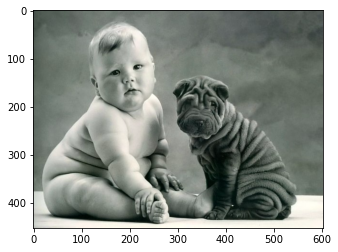

In [11]:
plt.imshow(image)
plt.show()

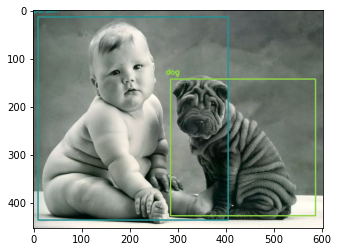

In [12]:
# apply non-max suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold) #удаляет рамки с сильным перекрытием

# go through the detections remaining
# after nms and draw bounding box
for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

# display output image    
plt.imshow(image) 
